# MUTAG Example

In [1]:
import numpy as np
import networkx as nx
import math
import time
import datetime
import os
import pickle as pkl
import seaborn as sns

import sys
sys.path.insert(0, '../')
import utils
from ahk import AHK_graphon

from matplotlib import pyplot as plt


Loaded  187  training graphs 

Training samples:


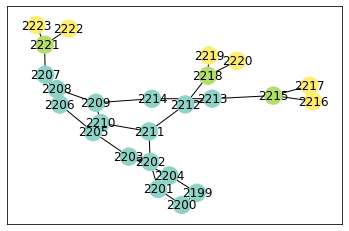

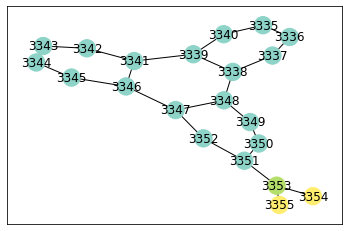

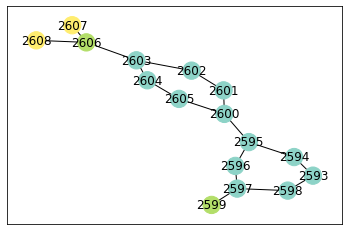

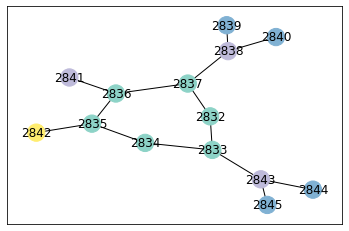

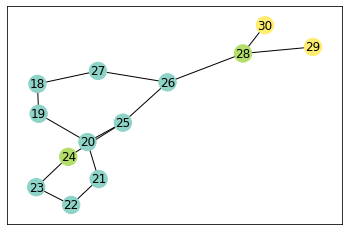

Query graph:


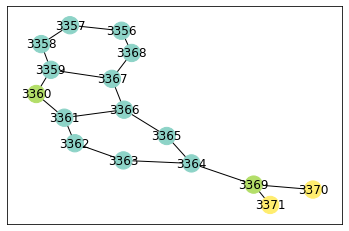

In [2]:
# Load training data and display some examples:
mutagdata_nx=pkl.load(open("../dataset/MUTAG/mutag.pkl","rb"))
traindata_nx=mutagdata_nx[:-1]
querygraph_nx=mutagdata_nx[-1]

print("Loaded ", len(traindata_nx), " training graphs \n")

print("Training samples:")

idxs=np.random.randint(len(traindata_nx), size=5)
for idx in idxs:
    colors=list(traindata_nx[idx].nodes[n]['label'] for n in traindata_nx[idx].nodes())
    nx.draw_networkx(traindata_nx[idx],node_color=colors,cmap='Set3')
    plt.show()

print("Query graph:")
colors=list(querygraph_nx.nodes[n]['label'] for n in querygraph_nx.nodes())
nx.draw_networkx(querygraph_nx,node_color=colors,cmap='Set3')

# transform networkx graphs into world objects:

#attribute construction for MUTAG:
n=7
D={}
I=np.identity(n,dtype=int)
for i in range(n):
    D[i]=I[i,:]
atts=(["label"])
fmaps={"label":D}

traindata=utils.batch_nx_to_world(traindata_nx,featmaps=fmaps)

# Learn a model

In [25]:
# Learning settings:

# Initialize model
binbounds=utils.uni_bins(10)
learnmodel=AHK_graphon(traindata[0].sig,binbounds)

settings={}

settings['num_pi_b']=50
settings['batchsize']=5
settings['soft']=0.001
settings['numepochs']=50
settings['early_stop']=3 #Number of epochs with no log-likelihood improvement required for early stopping
settings['learn_bins']=False
settings['with_trace']=False
settings['randombatches']=False
settings['adaptbatchsize']=False
settings['ubias']=0.0
settings['savepath']='../Experiments/DAG/'

#Adam params:
settings['ad_alpha']=0.01
settings['ad_beta1']=0.9
settings['ad_beta2']=0.999
settings['ad_epsilon']=1e-8

settings['seed']=1
settings['method']="adam"

In [ ]:
# learn with fixed granularity:
rng=np.random.default_rng(seed=settings['seed'])
learnmodel.rand_init(rng)
best,loglik,_=learnmodel.learn_fixed_bins(settings,traindata,rng,exact_gradients=False,info_each_epoch=False)

# Inference

Use either learned model:

In [27]:
model=best

Or load model from file:

In [3]:
modelfile="../Experiments/MUTAG/model_learned.pkl"
model=pkl.load(open(modelfile,"rb"))

### Query graph

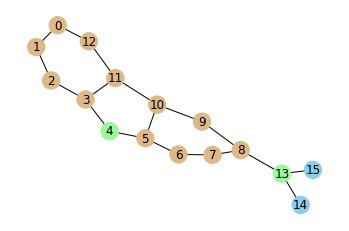

In [68]:

# Adjusting node identifiers (so that they are consecutive numbers 0,1,...):
querygraph_nx=nx.convert_node_labels_to_integers(querygraph_nx)

# Defining colors for the three relevant node labels (elements)
coldict={}
coldict[-1.0]="white" # unknown
coldict[0.0]="burlywood" # carbon
coldict[1.0]="palegreen" # nitrogen
coldict[2.0]="skyblue" # oxygen



layout=nx.spring_layout(querygraph_nx)
nodecols=(list(coldict[querygraph_nx.nodes()[j]['label']] for j in querygraph_nx.nodes()))
plt.axis("off")
nx.draw_networkx(querygraph_nx,pos=layout,node_color=nodecols)
plt.show()



# transforming networkx graph into world
n=7
D={}
I=np.identity(n,dtype=int)
for i in range(n):
    D[i]=I[i,:]
fmaps={"label":D}

w=utils.nx_to_world(querygraph_nx,featmaps=fmaps)


### Defining the queries for the full molecule

In [71]:

## Mark elements of queryatoms 0,1,2,13,14,15 as unknown:
qatts=[0,1,2,13,14,15]
for a in qatts:
    w.unaries[a,0]=-1


## Create joint queries for 0,1,2 and 13,14,15:     
query=[]
qdict={}
eldict={0:"C",1:"N",2:"O"}
for a in qatts:
    for el in range(3):
        query.append([(0,a,el)])
        qdict[str([(0,a,el)])]=eldict[el]
        

qtriplets=[[1,0,2],[13,14,15]] #"center" node first in this tuple  
for tr in qtriplets:
    for el in range(3):
        for ell in range(3):
            query.append([(0,tr[0],el),(0,tr[1],ell),(0,tr[2],ell)])
            qdict[str([(0,tr[0],el),(0,tr[1],ell),(0,tr[2],ell)])]=eldict[ell]+"-"+eldict[el]+"-"+eldict[ell]

for q in query:
    print("query: ", q)

query:  [(0, 0, 0)]
query:  [(0, 0, 1)]
query:  [(0, 0, 2)]
query:  [(0, 1, 0)]
query:  [(0, 1, 1)]
query:  [(0, 1, 2)]
query:  [(0, 2, 0)]
query:  [(0, 2, 1)]
query:  [(0, 2, 2)]
query:  [(0, 13, 0)]
query:  [(0, 13, 1)]
query:  [(0, 13, 2)]
query:  [(0, 14, 0)]
query:  [(0, 14, 1)]
query:  [(0, 14, 2)]
query:  [(0, 15, 0)]
query:  [(0, 15, 1)]
query:  [(0, 15, 2)]
query:  [(0, 1, 0), (0, 0, 0), (0, 2, 0)]
query:  [(0, 1, 0), (0, 0, 1), (0, 2, 1)]
query:  [(0, 1, 0), (0, 0, 2), (0, 2, 2)]
query:  [(0, 1, 1), (0, 0, 0), (0, 2, 0)]
query:  [(0, 1, 1), (0, 0, 1), (0, 2, 1)]
query:  [(0, 1, 1), (0, 0, 2), (0, 2, 2)]
query:  [(0, 1, 2), (0, 0, 0), (0, 2, 0)]
query:  [(0, 1, 2), (0, 0, 1), (0, 2, 1)]
query:  [(0, 1, 2), (0, 0, 2), (0, 2, 2)]
query:  [(0, 13, 0), (0, 14, 0), (0, 15, 0)]
query:  [(0, 13, 0), (0, 14, 1), (0, 15, 1)]
query:  [(0, 13, 0), (0, 14, 2), (0, 15, 2)]
query:  [(0, 13, 1), (0, 14, 0), (0, 15, 0)]
query:  [(0, 13, 1), (0, 14, 1), (0, 15, 1)]
query:  [(0, 13, 1), (0, 14,

### Running importance sampling

In [22]:
rng=np.random.default_rng()

runs=5
results=np.zeros((runs,len(query)))

for r in range(runs):
    p,_,_=model.importance_sample({},w,rng,query=query,numsamples=5000,with_trace=False,sampler='nonseq')
    results[r,:]=p

In [31]:
results_avg=np.average(results,axis=0)
results_std=np.std(results,axis=0)

In [33]:
for q in range(len(results_avg)):
    args=list(at[1] for at in query[q])
    print(args,qdict[str(query[q])], results_avg[q],"+/-", results_std[q])

[0] C 0.5929597436861699 +/- 0.006464751702316367
[0] N 0.18298951505620445 +/- 0.007633169361639814
[0] O 0.08455402068620438 +/- 0.006182512033845612
[1] C 0.5823050725976948 +/- 0.017041054800071637
[1] N 0.12152337339728665 +/- 0.0055943703869697665
[1] O 0.1593390539328786 +/- 0.016122379344909
[2] C 0.5951056691020469 +/- 0.011221855757250819
[2] N 0.18968156921235974 +/- 0.01250325793711347
[2] O 0.08084665415490574 +/- 0.006015022851458938
[13] C 0.37643135125694416 +/- 0.022339768556912363
[13] N 0.4418015399725238 +/- 0.02877639042738386
[13] O 0.06425195310064753 +/- 0.009912478175945306
[14] C 0.35489750848497437 +/- 0.01829081639775275
[14] N 0.12880036924010851 +/- 0.022034728357294805
[14] O 0.4028913938350037 +/- 0.027029105056328
[15] C 0.3594561073249978 +/- 0.02500496781628915
[15] N 0.12708103110356908 +/- 0.01977867147244439
[15] O 0.4008991384846448 +/- 0.027623433208461622
[1, 0, 2] C-C-C 0.2513884429796648 +/- 0.00814994969809085
[1, 0, 2] N-C-N 0.01085208737917

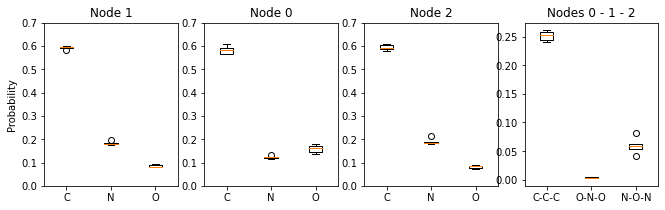

In [76]:
fig,axes=plt.subplots(1,4,figsize=(11,3))

tidx = 0 # 0 for nodes 0,1,2; 1 for nodes 13,14,15

qtrip=qtriplets[tidx]
titles=[]
for i in range(3):
    titles.append("Node " + str(qtrip[i]))
titles.append("Nodes {} - {} - {}".format(qtrip[1],qtrip[0],qtrip[2]))

slices=[]
if tidx==0:
    slices.append(np.s_[0:3])
    slices.append(np.s_[3:6])
    slices.append(np.s_[6:9])
    qidx=(18,23,25)
    slices.append(np.s_[qidx])

if tidx==1:
    slices.append(np.s_[9:12])
    slices.append(np.s_[12:15])
    slices.append(np.s_[15:18])
    qidx=(27,32,34)
    slices.append(np.s_[qidx])

    
for a in range(3):
    labels=list(qdict[str(query[q])] for q in range(3))
    axes[a].boxplot(results[:,slices[a]],labels=labels)
    if a==0:
        axes[a].set_ylabel("Probability")
    axes[a].set_title(titles[a])
    axes[a].set_ylim((0,0.7))
labels= list(qdict[str(query[q])] for q in qidx)   
axes[3].boxplot(results[:,slices[3]],labels=labels)
axes[3].set_title(titles[3])
plt.show()

# Illustrating importance sampling

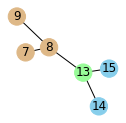

In [69]:
# use the radius 2 ego graph of node 13:
ego13_small_nx=nx.ego_graph(querygraph_nx,13,radius=2)
nodecols=(list(coldict[ego13_small_nx.nodes()[j]['label']] for j in ego13_small_nx.nodes()))
plt.figure(figsize=(2,2))
plt.axis("off")
nx.draw_networkx(ego13_small_nx,pos=layout,node_color=nodecols)
plt.show()

ego13_small=utils.nx_to_world(ego13_small_nx,featmaps=fmaps)

Computing the exact probabilities P(pi,b,w):

In [47]:
_,p,PIU=model.compute_prob(ego13_small,return_pibs=True)

Computing the probability P(w) by importance sampling, and returning the empirical sampling distribution over pi,b:

In [48]:
numsamples=100000
rng=np.random.default_rng()
pnew,_,SPIU=model.importance_sample({},ego13_small,rng,return_pibs=True,\
                                     numsamples=numsamples,sampler="nonseq",verbose=False,with_trace=False)

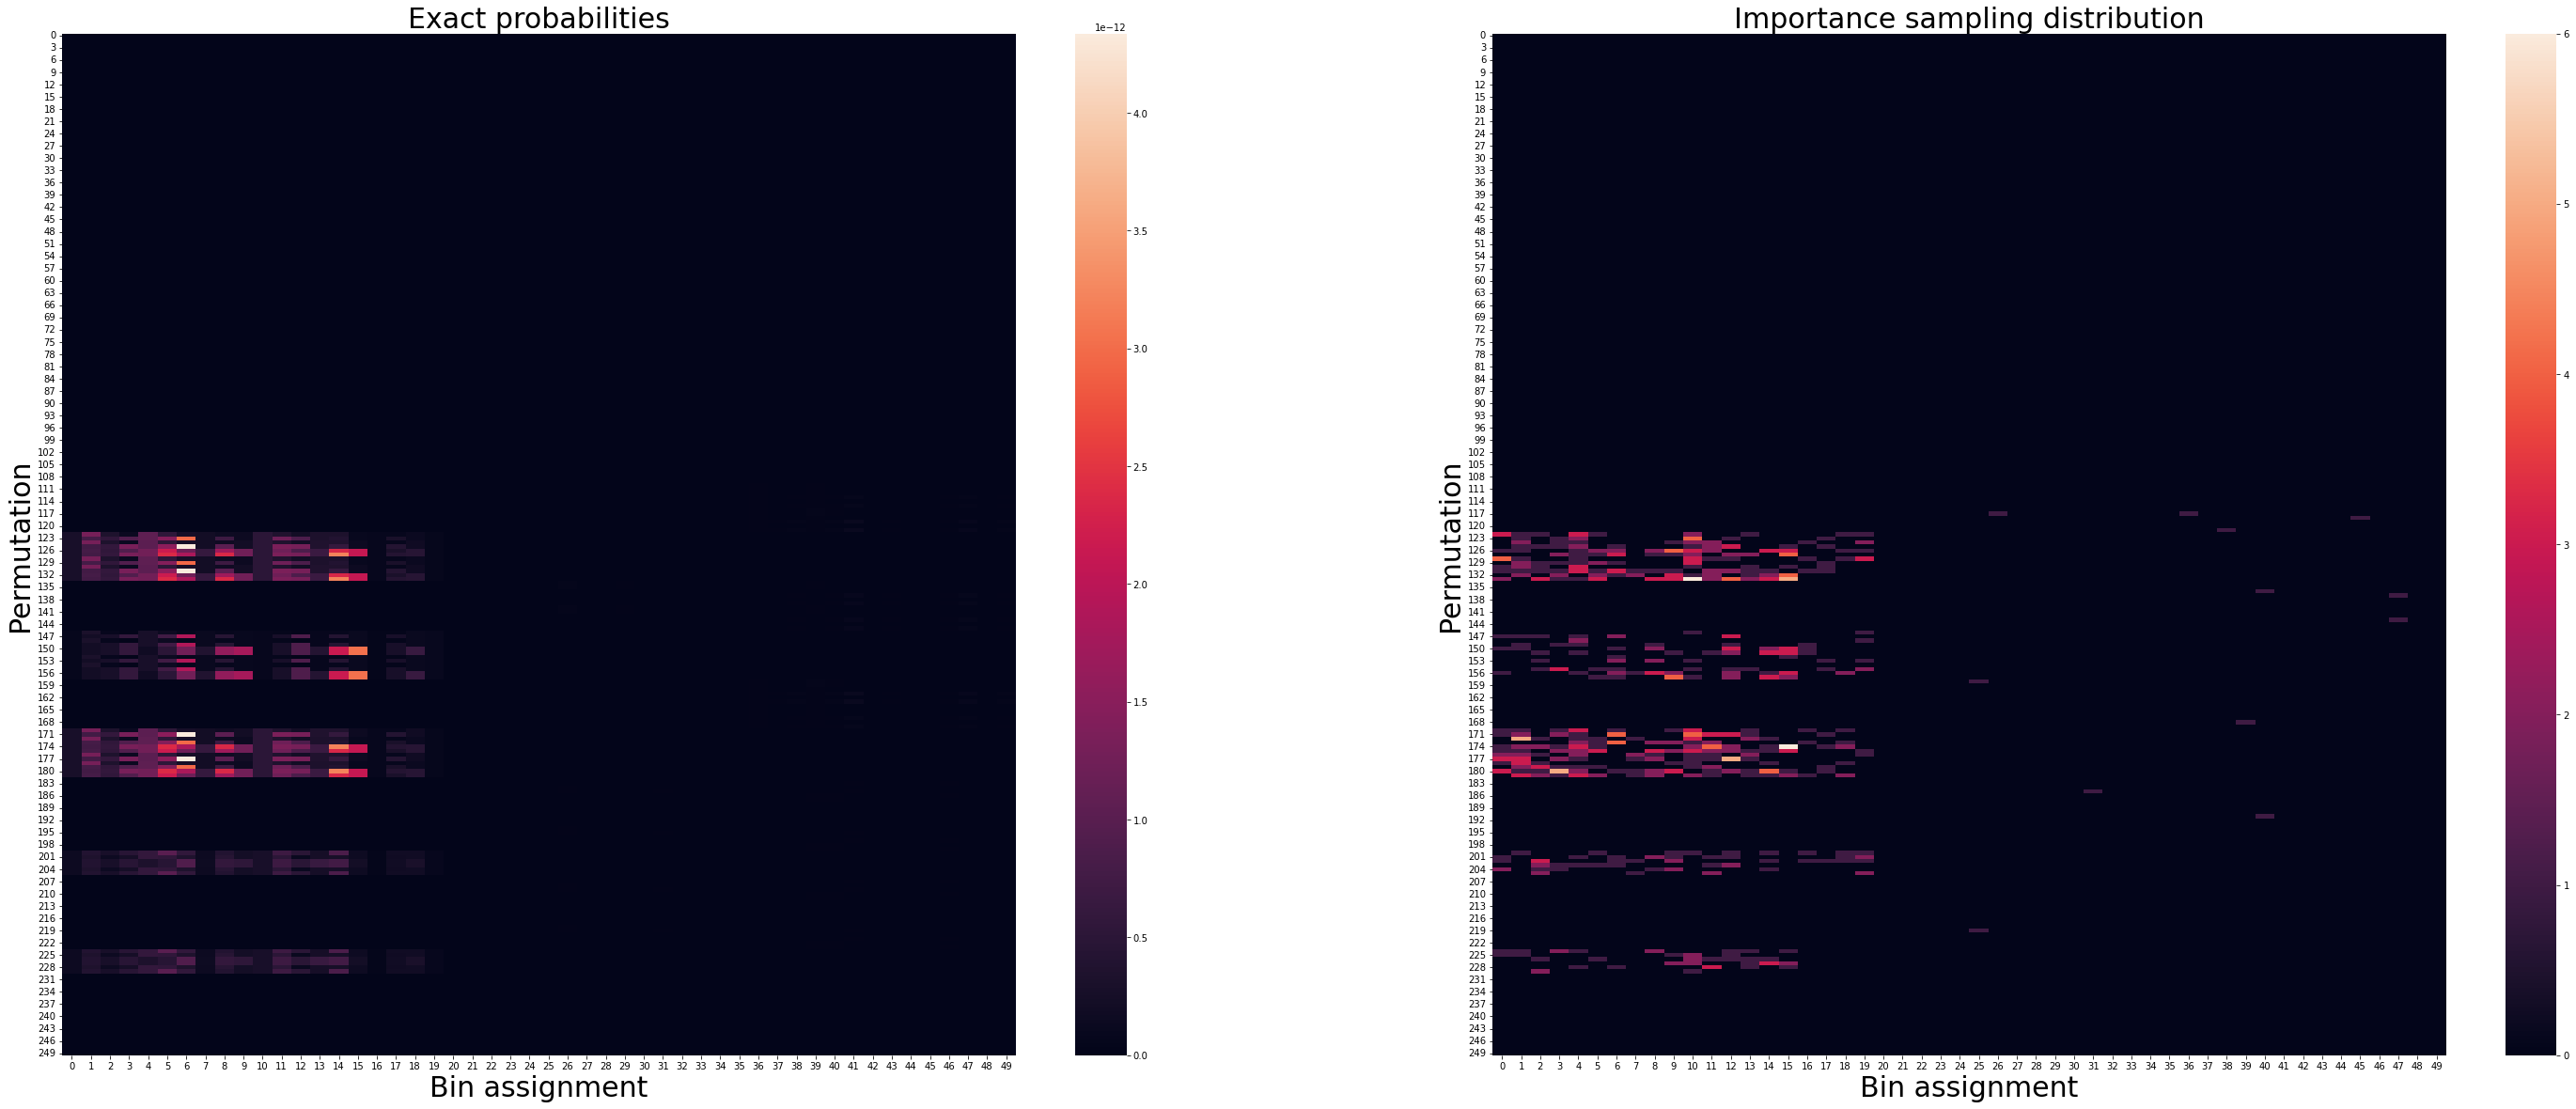

In [54]:
xslice=slice(1450,1500)
yslice=slice(250,500)

plt.rcParams['axes.labelsize']=30

fig,axes=plt.subplots(1,2,figsize=(50,20))
sns.heatmap((PIU[yslice,xslice]),ax=axes[0])
sns.heatmap(SPIU[yslice,xslice],ax=axes[1])
axes[0].set_xlabel("Bin assignment")
axes[0].set_ylabel("Permutation")
axes[0].set_title("Exact probabilities", size=30)
axes[1].set_xlabel("Bin assignment")
axes[1].set_ylabel("Permutation")
axes[1].set_title("Importance sampling distribution", size=30)
plt.show()